In [1]:
# Importa as bibliotecas necessárias
%run '~/git/Bibliotecas.ipynb'

In [2]:
# Carrega a base de dados contendo os registros de importação de fertilizantes
q=pd.read_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/q.csv').rename(columns={'CO_MES':'Mês'})

In [3]:
# Formata coluna date para guiar o eixo x dos gráficos
q.date=pd.to_datetime(q.date)

# Recria as colunas de Ano para permitir visualização agrupada
q['Ano']=q.date.dt.year

In [4]:
# Determina a diferença entre a média dos erros absolutos das importações em kilo ton/mês, com e sem o uso dos dados sobre chuva como _input_
q['teste_estatístico_kton_mês']=q.erro_testemunha-q.erro_tratamento

print(f"\
\nEm média o erro absoluto da amostra testemunha é {round(q['teste_estatístico_kton_mês'].mean())} kton/mês maior do que o erro do tratamento.\
\n\nCom base nessa diferença, levanta-se a hipótese (Ha) de que o erro do tratamento é menor em toda a população de dados.\n")


Em média o erro absoluto da amostra testemunha é 5 kton/mês maior do que o erro do tratamento.

Com base nessa diferença, levanta-se a hipótese (Ha) de que o erro do tratamento é menor em toda a população de dados.



Os anos de registros serão aqui considerados a repetição dos tratamentos.  

# Formalizando o teste de hipóteses

In [5]:
# revendo o teste de hipótese definido no capítulo 1
%run '~/git/Pricing-Fertilizer-take-Rains-into-account/1. Asking an interesting question.ipynb'


Teste de Hipótese

Sobre as variáveis preditivas para projeção das importações:

Testemunha: Considera somente a unidade de tempo

Tratamento: Considera adicionalmente as quantidades de chuva

Teste estatístico = Erro Absoluto Médio (mae) da testemunha menos o do tratamento

Ho: O teste estatístico não difere de zero
Ha: O teste estatístico é maior do que zero ("Left Tail Teste")

A significância estatística deve ser de 0.05 (aplha=0.05)


In [6]:
alpha=0.05

In [7]:
# Define o estilo dos gráficos
plt.style.use('ggplot')

In [8]:
# Define o título dos gráficos
title='Superioridade do Erro do Testemunha'

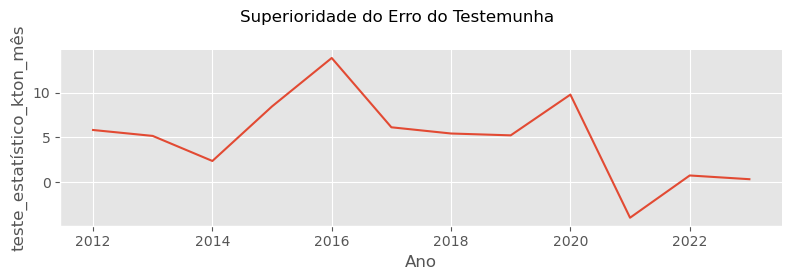

In [9]:
# Viauliza a variável anualizada
sns.relplot(data=q.groupby('Ano').teste_estatístico_kton_mês.mean().reset_index(),x='Ano',y='teste_estatístico_kton_mês',\
            kind='line',height=2.5,aspect=2*1.6)\
.fig.suptitle(title,y=1.1)
plt.show()

> Vemos acima que a vantagem do tratatemento sobre a testemunha se manteve positivo durante todos os anos registrados com excessão do ano de 2021, marcado pela pandemia mundial. Isso é uma forte razão para acreditarmos na Ha!

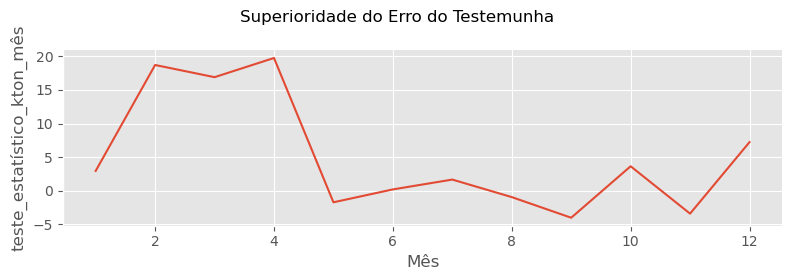

In [10]:
sns.relplot(data=q.groupby('Mês').teste_estatístico_kton_mês.mean().reset_index(),x='Mês',y='teste_estatístico_kton_mês',\
            kind='line',height=2.5,aspect=2*1.6)\
.fig.suptitle(title,y=1.1)
plt.show()

Como os meses são considerados categorias de clima, equivalem a tratamentos.  Para seguir em análise, apenas um único mês deve ser escolhido, de forma a evitar concorência com o tratamento proposto.
Porém aqui desejamos comparar somente o tratamento referente a chuva.  

Assim, será selecionado para seguir em análise:  
* o mês de mais vantajoso do tratamento sobre a testemunha (H_pos).
* o mês de menos vantajoso do tratamento sobre a testemunha (H_neg).

In [11]:
mes_pos=q.groupby('Mês').teste_estatístico_kton_mês.mean().reset_index().sort_values('teste_estatístico_kton_mês').Mês.values[-1]
mes_pos

4

Salvamos também a identificação do mês menos positivo, para realizar um segundo teste, oposto ao primeiro.

In [12]:
mes_neg=q.groupby('Mês').teste_estatístico_kton_mês.mean().reset_index().sort_values('teste_estatístico_kton_mês').Mês.values[0]
mes_neg

9

Filtra tratamentos desejados e separa os testes positivos e negativos

In [13]:
q_pos=q[q.Mês==mes_pos]
q_pos.columns

Index(['kton', 'mm', 'date', 'kton_pred_tratamento', 'kton_pred_testemunha',
       'ad', 'train_size_anos', 'md', 'erro_tratamento', 'erro_testemunha',
       'Mês', 'Ano', 'teste_estatístico_kton_mês'],
      dtype='object')

In [14]:
q_neg=q[q.Mês==mes_neg]

Calculating the z-score and p-value

Nesse teste utilizaremos somente o mês de melhor desempenho do tratamento (q_pos)

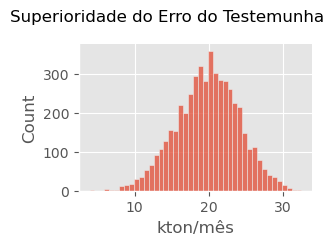

p_value=0.0


In [15]:
# Step 3. Repeat steps 1 & 2 many times, appending to a list
so_boot_distn = []
for i in range(5000):
    so_boot_distn.append(q_pos.sample(frac=1, replace=True)['teste_estatístico_kton_mês'].mean())

sns.displot(so_boot_distn,height=2,aspect=1.6).fig.suptitle(title,y=1.1)
plt.xlabel('kton/mês')
plt.show()

m=np.mean(so_boot_distn)
s=np.std(so_boot_distn,ddof=1)

z_score=(0-m)/s

from scipy.stats import norm
p=round(norm.cdf(z_score,loc=0,scale=1),3)
print(f"p_value={p}")

In [16]:
if p<=alpha:
    print(f'Pelo método paramétrico, com significância de {alpha}, "reject Ho".')
else:
    print(f'Pelo método paramétrico, com significância de {alpha}, "fail to reject Ho".')
    

Pelo método paramétrico, com significância de 0.05, "reject Ho".


> Apesar de termos rejeitada a hipótese nula com 0.05% de significância, visualmente se pode notar algumas anormalidades dos valores da reamostragem. Isso ocorre devido a baixo número de amostras originais.

In [17]:
print(f"O método determina que sejam de no mínimo 30 amostras originais.\n\
O número de amostras no teste positivo foi de {len(q_pos)}.")

O método determina que sejam de no mínimo 30 amostras originais.
O número de amostras no teste positivo foi de 11.


Nessa situação de baixo número de amostras originais,a alternativa são métodos não paramétricos, como o de Wilcoxon.

In [18]:
import pingouin

p_w=pingouin.wilcoxon(
    x=q_pos.erro_tratamento,
    y=q_pos.erro_testemunha,
    alternative='less'
)
p_w

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,3.0,less,0.002441,-0.909091,0.743802


In [19]:
p=p_w['p-val'].values[0]

In [20]:
if p<=alpha:
    print(f'Por método não paramétrico, com significância de {alpha}, "reject Ho".')
else:
    print(f'Por método não paramétrico, com significância de {alpha}, "fail to reject Ho".')
    

Por método não paramétrico, com significância de 0.05, "reject Ho".


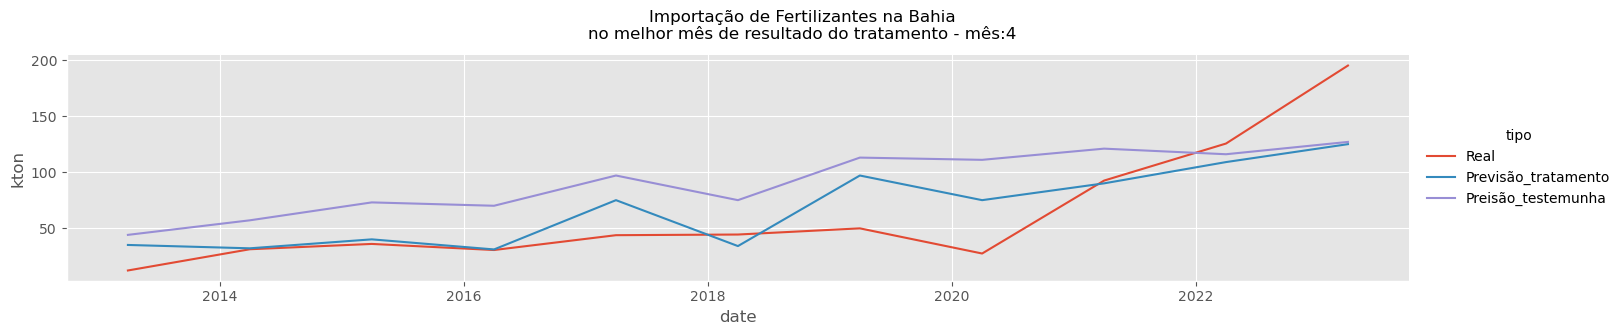

In [21]:
p1=q_pos[['date','kton']].reset_index(drop=True).assign(tipo='Real')

p2=q_pos[['date','kton_pred_tratamento']].reset_index(drop=True).assign(tipo='Previsão_tratamento')\
.rename(columns={'kton_pred_tratamento':'kton'})

p3=q_pos[['date','kton_pred_testemunha']].reset_index(drop=True).assign(tipo='Preisão_testemunha')\
.rename(columns={'kton_pred_testemunha':'kton'})

q_pos_l=pd.concat([p1,p2,p3]).dropna()

sns.relplot(data=q_pos_l,x='date',y='kton',hue='tipo', kind='line',height=3,aspect=3*1.6)\
.fig.suptitle(f'Importação de Fertilizantes na Bahia\n\
no melhor mês de resultado do tratamento - mês:{mes_pos}',y=1.1)
plt.show()

# Conclusão  
* Rejeitou-se a hipótese nula com significância estatística de 0.05
* Utilizar dados de chuva como variável preditiva pode reduzir produzir previsões mais precisas, como essa do gráfico acima.

# Nova Pergunta (bônus):  

O processamento dos dados de chuvas pode reduzir a precisão da previsão de importação?

Teste de Hipótese

Sobre as variáveis preditivas das importações:

* Testemunha: Considera somente a unidade de tempo
* Tratamento: Considera adicionalmente as quantidades de chuva

Teste estatístico = No mês de pior desempenho do tratamento, o Erro Absoluto Médio (mae) da testemunha menos o mae do tratamento.

* Ho: O teste estatístico não difere de zero
* Ha: O teste estatístico menor do que zero ("Right Tail test")

A significância estatística deve ser de 0.05 (aplha=0.05)

Calculating the z-score and p-value

Nesse novo teste utilizaremos somente o mês de pior desempenho do tratamento (q_neg)

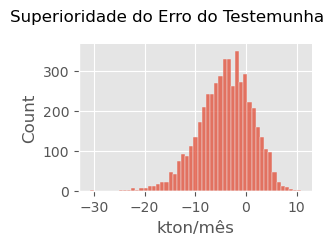

p_value=0.21799999999999997


In [22]:
# Step 3. Repeat steps 1 & 2 many times, appending to a list
so_boot_distn = []
for i in range(5000):
    so_boot_distn.append(q_neg.sample(frac=1, replace=True)['teste_estatístico_kton_mês'].mean())

sns.displot(so_boot_distn,height=2,aspect=1.6).fig.suptitle(title,y=1.1)
plt.xlabel('kton/mês')
plt.show()

m=np.mean(so_boot_distn)
s=np.std(so_boot_distn,ddof=1)

z_score=(0-m)/s

from scipy.stats import norm
p=1-round(norm.cdf(z_score,loc=0,scale=1),3)
print(f"p_value={p}")

Podemos ver que a superioridade do erro da testemunha é negativa, ou seja, a testemunha tem erro menor em média.

In [23]:
if p<=alpha:
    print(f'Pelo método paramétrico, com significância de {alpha}, "reject Ho".')
else:
    print(f'Pelo método paramétrico, com significância de {alpha}, "fail to reject Ho".')
    

Pelo método paramétrico, com significância de 0.05, "fail to reject Ho".


> Apesar de termos rejeitada a hipótese nula com 0.05% de significância, visualmente se pode notar algumas anormalidades dos valores da reamostragem. Isso ocorre devido a baixo número de amostras originais.

In [24]:
print(f"O método determina que sejam de no mínimo 30 amostras originais.\n\
O número de amostras no teste positivo foi de {len(q_pos)}.")

O método determina que sejam de no mínimo 30 amostras originais.
O número de amostras no teste positivo foi de 11.


Nessa situação de baixo número de amostras originais,a alternativa são métodos não paramétricos, como o de Wilcoxon.

In [25]:
import pingouin

p_w=pingouin.wilcoxon(
    x=q_neg.erro_testemunha,
    y=q_neg.erro_tratamento,
    alternative='less'
)
p_w

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,24.0,less,0.379883,-0.127273,0.479167


In [26]:
p=p_w['p-val'].values[0]

In [27]:
if p<=alpha:
    print(f'Por método não paramétrico, com significância de {alpha}, "reject Ho".')
else:
    print(f'Por método não paramétrico, com significância de {alpha}, "fail to reject Ho".')
    

Por método não paramétrico, com significância de 0.05, "fail to reject Ho".


# Nova Conclusão

* Falhou-se em rejeitar a hipótese nula com significância estatística de .0.05.
* Adcionar os dados de chuva como variável preditiva pode produzir previsões menos precisas, como essa do gráfico abaixo.

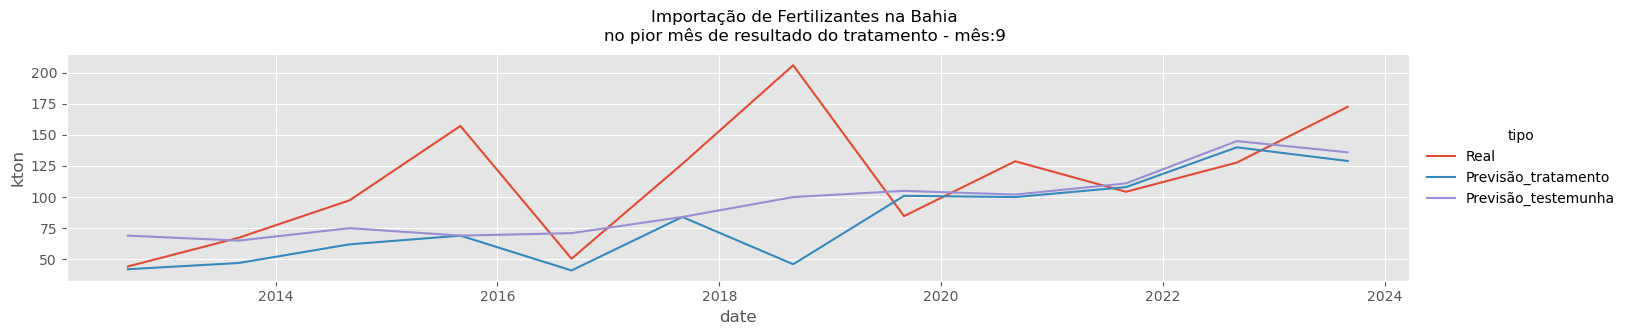

In [28]:
p1=q_neg[['date','kton']].reset_index(drop=True).assign(tipo='Real')

p2=q_neg[['date','kton_pred_tratamento']].reset_index(drop=True).assign(tipo='Previsão_tratamento')\
.rename(columns={'kton_pred_tratamento':'kton'})

p3=q_neg[['date','kton_pred_testemunha']].reset_index(drop=True).assign(tipo='Previsão_testemunha')\
.rename(columns={'kton_pred_testemunha':'kton'})

q_neg_l=pd.concat([p1,p2,p3]).dropna()

sns.relplot(data=q_neg_l,x='date',y='kton',hue='tipo', kind='line', height=3,aspect=3*1.6)\
.fig.suptitle(f'Importação de Fertilizantes na Bahia\n\
no pior mês de resultado do tratamento - mês:{mes_neg}',y=1.1)
plt.show()

In [29]:
q_pos=q[ q.Mês.isin([12,1,2,3,4,5])].sort_values('date')
q_neg=q[~q.Mês.isin([12,1,2,3,4,5])].sort_values('date')

In [30]:
q_pos['kton_mmv']=q_pos['kton'].rolling(6).mean()
q_pos['kton_pred_testemunha_mmv']=q_pos['kton_pred_testemunha'].rolling(6).mean()
q_pos['kton_pred_tratamento_mmv']=q_pos['kton_pred_tratamento'].rolling(6).mean()

In [31]:
q_neg['kton_mmv']=q_neg['kton'].rolling(6).mean()
q_neg['kton_pred_testemunha_mmv']=q_neg['kton_pred_testemunha'].rolling(6).mean()
q_neg['kton_pred_tratamento_mmv']=q_neg['kton_pred_tratamento'].rolling(6).mean()

# Conclusão Final

* Concatenando as duas conclusões anteriores
* Com significância estatística de 0.05 se pode afirmar que adicionar dados de chuva como variável preditiva pode resultar em previsões mais precisas e menos precisas, a depender do mês que se pretende prever, como se pode ver nos dois gráficos abaixo.

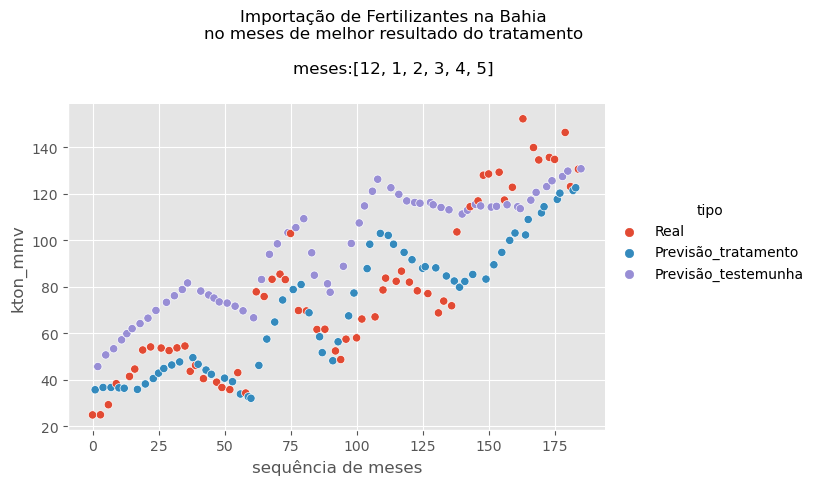

In [46]:
p1=q_pos[['date','kton_mmv']]                .reset_index(drop=True).assign(tipo='Real')

p2=q_pos[['date','kton_pred_tratamento_mmv']].reset_index(drop=True).assign(tipo='Previsão_tratamento')\
.rename(columns={'kton_pred_tratamento_mmv':'kton_mmv'})

p3=q_pos[['date','kton_pred_testemunha_mmv']].reset_index(drop=True).assign(tipo='Previsão_testemunha')\
.rename(columns={'kton_pred_testemunha_mmv':'kton_mmv'})

q_pos_l=pd.concat([p1,p2,p3]).dropna().sort_values('date').reset_index()

_=sns.relplot(data=q_pos_l,x=q_pos_l.index,y='kton_mmv',hue='tipo', height=4,aspect=1.6)\
.fig.suptitle(f'Importação de Fertilizantes na Bahia\n\
no meses de melhor resultado do tratamento\n\n\
meses:{q_pos.Mês.unique().tolist()}',y=1.2)


_=plt.xlabel('sequência de meses')

fig=_.get_figure()

fig.savefig('best_result.png')

plt.show()

In [ ]:
p1=q_neg[['date','kton_mmv']]                .reset_index(drop=True).assign(tipo='Real')

p2=q_neg[['date','kton_pred_tratamento_mmv']].reset_index(drop=True).assign(tipo='Previsão_tratamento')\
.rename(columns={'kton_pred_tratamento_mmv':'kton_mmv'})

p3=q_neg[['date','kton_pred_testemunha_mmv']].reset_index(drop=True).assign(tipo='Previsão_testemunha')\
.rename(columns={'kton_pred_testemunha_mmv':'kton_mmv'})

q_neg_l=pd.concat([p1,p2,p3]).dropna().sort_values('date').reset_index()

sns.relplot(data=q_neg_l,x=q_neg_l.index,y='kton_mmv',hue='tipo', height=4,aspect=1.6)\
.fig.suptitle(f'Importação de Fertilizantes na Bahia\n\
nos meses de pior resultado do tratamento\n\n\
meses:{q_neg.Mês.unique().tolist()}',y=1.2)
plt.xlabel('sequência de meses')
plt.show()